# In Depth Analysis of MongoDB Stock
- Showcasing functions built specifically for EDA and Modeling of stock time series forecasting
- Historical stock data obtained from finance.yahoo.com
- Using ARIMA, Auto Arima and Facebook Prophet models

# Business Case
- Finding the highest growth in 60 days for investments

In [1]:
from Functions import *

In [2]:
df = pd.read_csv('Data/MongoDB.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/19/2017,33.000000,34.000000,29.100000,32.07,32.07,11508500
1,10/20/2017,33.369999,33.369999,30.100000,30.68,30.68,2358700
2,10/23/2017,30.510000,31.330000,30.190001,30.50,30.50,749400
3,10/24/2017,30.459999,30.920000,30.438999,30.57,30.57,420700
4,10/25/2017,30.500000,31.100000,29.879999,31.00,31.00,1219400


# Preprocessing Function
- From the default stock data provided, we want to look at the change in Adj Close price over time (days)
- The Volume will be our exogenous variable

In [4]:
X, Xvol = preprocess(init_data=df,exog=True)

In [5]:
X.head()

Date
2017-10-19    32.07
2017-10-20    30.68
2017-10-23    30.50
2017-10-24    30.57
2017-10-25    31.00
Name: Adj Close, dtype: float64

In [6]:
Xvol.head()

Date
2017-10-19    11508500
2017-10-20     2358700
2017-10-23      749400
2017-10-24      420700
2017-10-25     1219400
Name: Volume, dtype: int64

## Log Transformations and FB Prophet Prep
- Preprocessing can perform log transformations on the data
- Can also shape the data in the format used by Prophet

In [7]:
Xlog, Xvollog = preprocess(init_data=df, exog=True, logged=True)
Xfb = preprocess(init_data=df,facebook=True)

In [8]:
Xlog.head()

Date
2017-10-19    3.467921
2017-10-20    3.423611
2017-10-23    3.417727
2017-10-24    3.420019
2017-10-25    3.433987
Name: Adj Close, dtype: float64

In [9]:
Xfb.head()

,ds,y
0,2017-10-19,32.07
1,2017-10-20,30.68
2,2017-10-23,30.50
3,2017-10-24,30.57
4,2017-10-25,31.00


# Train Test Split for Time Series
- Instead of taking random samples of the data, train test split sets a cutoff date for training and testing data
- The same preprocessing above is built in to the split, along with log transform and prophet set up
- Default split is 75% Train, 25% Test

In [10]:
Xtrain,Xtrainvol,Xtest,Xtestvol = train_test(df,exog=True)

In [11]:
Xtrain.head()

Date
2017-10-19    32.07
2017-10-20    30.68
2017-10-23    30.50
2017-10-24    30.57
2017-10-25    31.00
Name: Adj Close, dtype: float64

In [12]:
Xtest.head()

Date
2020-10-26    240.100006
2020-10-27    244.009995
2020-10-28    240.039993
2020-10-29    235.690002
2020-10-30    228.470001
Name: Adj Close, dtype: float64

In [13]:
length_data = len(df)
length_train = len(Xtrain)
length_test = len(Xtest)
print('Total Data Length:',length_data)
print('Train Length:', length_train, length_train/length_data*100,"%")
print('Test Length:', length_test, length_test/length_data*100,"%")

Total Data Length: 1012
Train Length: 759 75.0 %
Test Length: 253 25.0 %


# ARIMA Order Parameters
- These functions provide intial p,d,q values from ACF, PACF and Dickey-Fuller tests

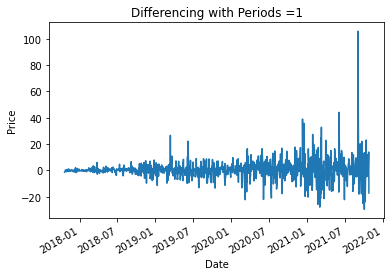

In [14]:
d = return_d(data=X,plotting=True)

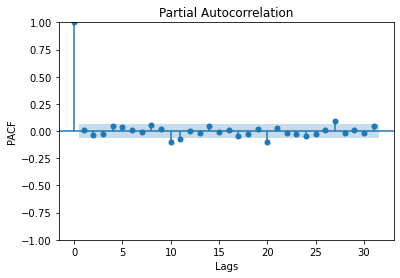

In [15]:
p = return_p(data=X,plotting=True) # Uses differenced data to calculate PACF

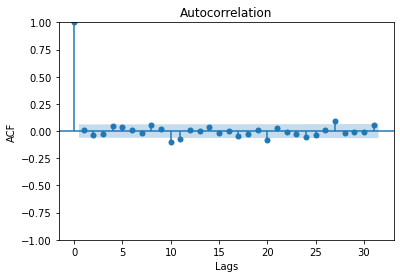

In [16]:
q = return_q(data=X,plotting=True) # Uses differenced data to calculate ACF

In [17]:
print("p = ",p)
print("d = ",d)
print("q = ",q)

p =  0
d =  1
q =  0


# Modeling

## Base ARIMA Model

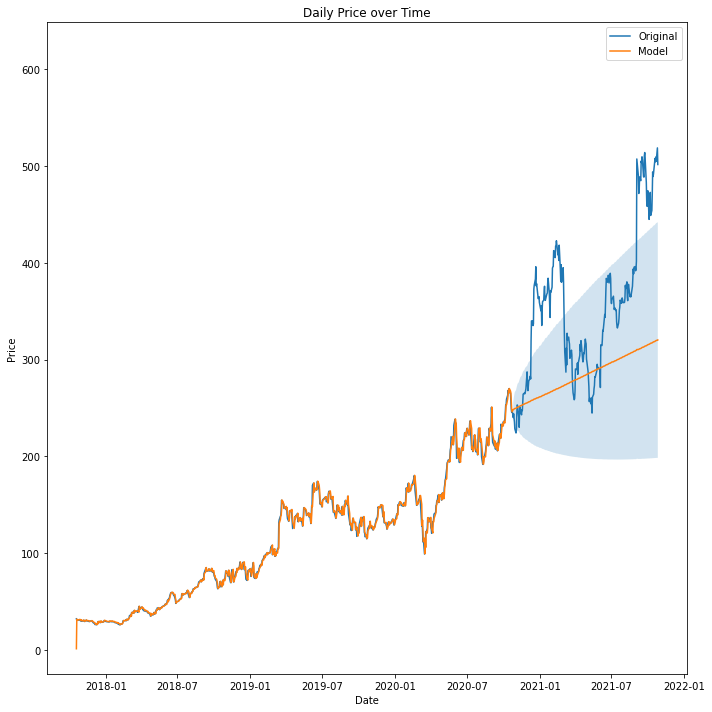

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  759
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2241.718
Date:                Sun, 14 Nov 2021   AIC                           4489.435
Time:                        16:21:52   BIC                           4503.327
Sample:                             0   HQIC                          4494.785
                                - 759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2859      0.183      1.566      0.117      -0.072       0.644
Volume      7.089e-08   9.42e-08      0.752      0.452   -1.14e-07    2.56e-07
sigma2        21.6920      0.620     35.009      0.0

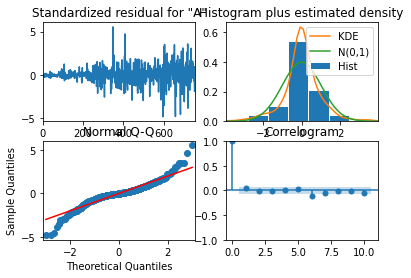

In [18]:
arima = base_model(df,exog=True,logged=False,plotting=True,summary=True,mse=True)

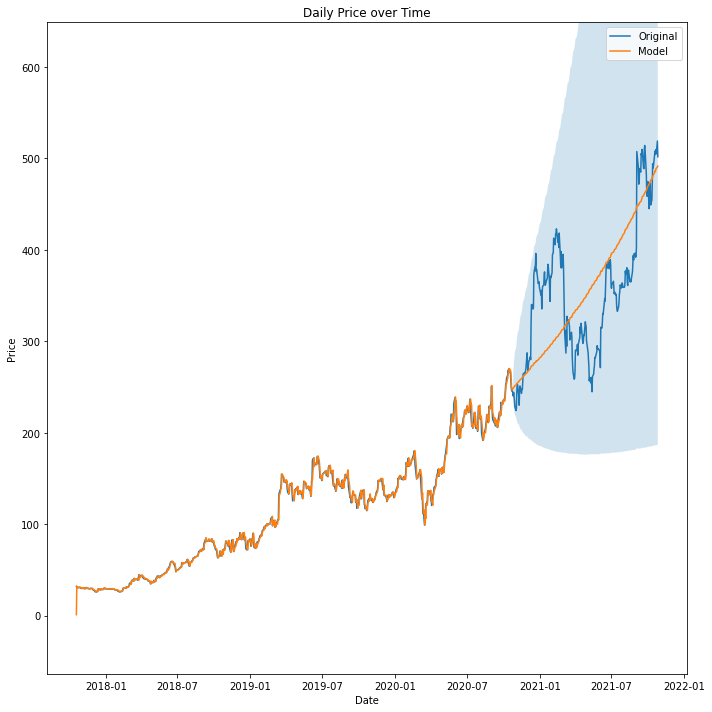

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  759
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1423.479
Date:                Sun, 14 Nov 2021   AIC                          -2840.958
Time:                        16:21:53   BIC                          -2827.065
Sample:                             0   HQIC                         -2835.607
                                - 759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.002      1.764      0.078      -0.000       0.006
Volume         0.0023      0.002      1.003      0.316      -0.002       0.007
sigma2         0.0014   4.21e-05     32.481      0.0

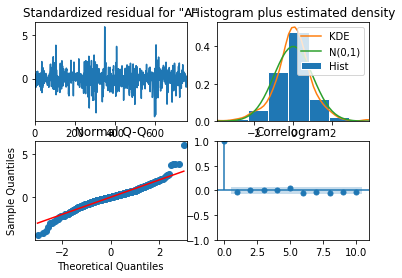

In [19]:
arima_logged = base_model(df,exog=True,logged=True,plotting=True,summary=True,mse=True)

### Base Model Findings
- Base ARIMA model has an AIC of 4489 and RMSE of 92
- Base ARIMA model with log transformed data has an AIC of -2840 and RMSE of 58
- In both metrics and visualization, the model with log transformed data performed better
- In both cases, it appears the Volume variable is insignificant

## Auto Arima Model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4478.800, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4487.592, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4487.080, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4486.999, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4488.422, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4480.460, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4480.513, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4488.916, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4492.609, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4492.633, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4480.974, Time=1.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4479.588, Time=0.34 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] interc

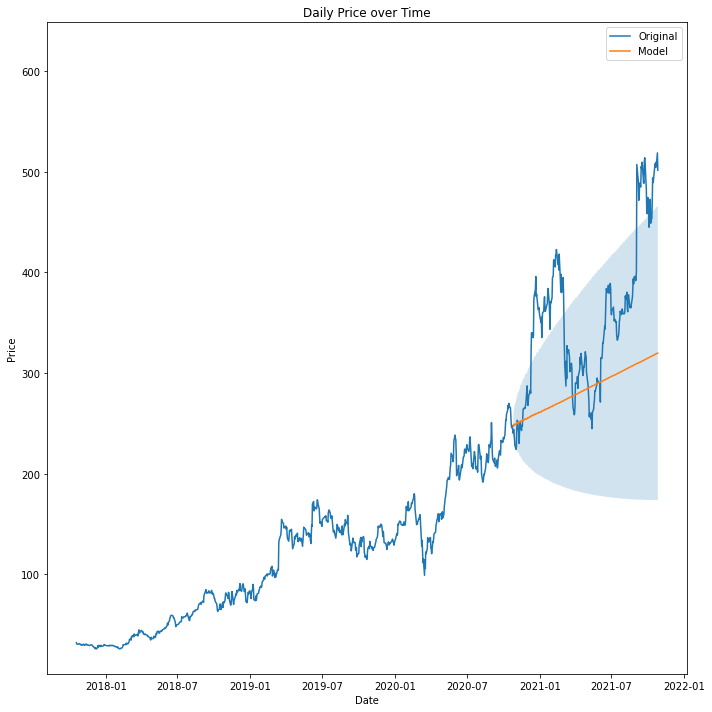

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  759
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2233.400
Date:                Sun, 14 Nov 2021   AIC                           4478.800
Time:                        16:22:00   BIC                           4506.584
Sample:                             0   HQIC                          4489.500
                                - 759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5848      0.352      1.663      0.096      -0.105       1.274
ar.L1         -0.0882      0.023     -3.814      0.000      -0.134      -0.043
ar.L2         -0.9625      0.024    -40.573      0.0

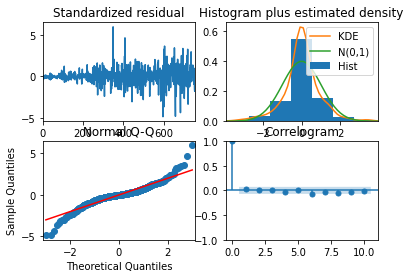

In [20]:
autoarima = create_auto_arima(df,exog=True,logged=False,plotting=True,summary=True,mse=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2834.919, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2842.212, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2840.910, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2840.905, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2840.194, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2838.918, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.929 seconds


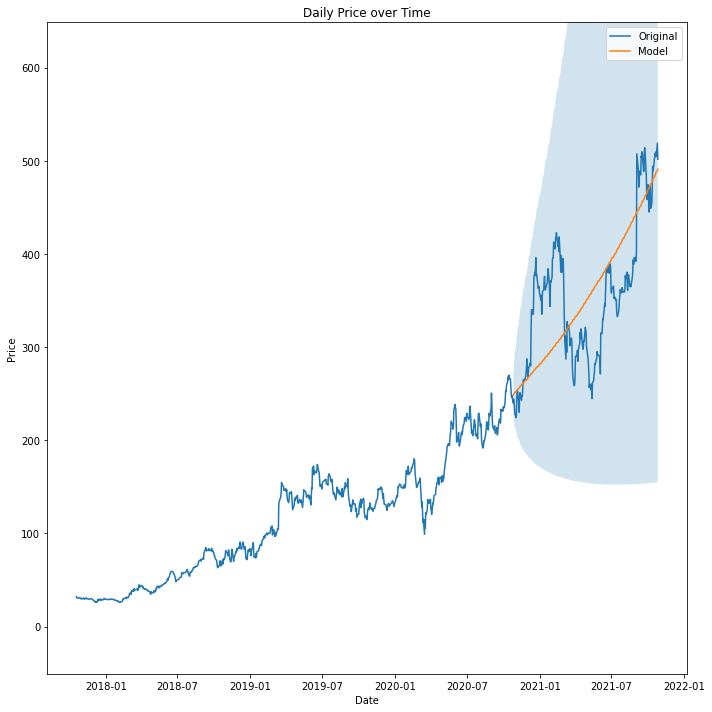

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  759
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1423.106
Date:                Sun, 14 Nov 2021   AIC                          -2842.212
Time:                        16:22:02   BIC                          -2832.951
Sample:                             0   HQIC                         -2838.645
                                - 759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      2.005      0.045    6.07e-05       0.005
sigma2         0.0014   4.19e-05     32.714      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.70   Jarque-

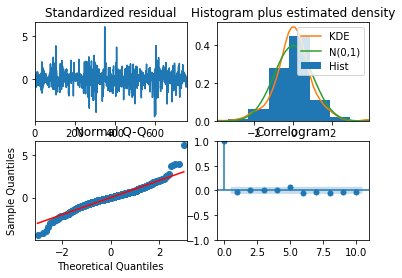

In [21]:
autoarima_logged = create_auto_arima(df,exog=True,logged=True,plotting=True,summary=True,mse=True)

### Auto ARIMA Findings
- The auto ARIMA model with untransformed data performed almost the same as the base ARIMA model.  AIC = 4478 and RMSE = 92.4
- The auto ARIMA model with log transformed data also performed better with similar results to base ARIMA with transformed data. AIC = -2842 and RMSE = 58
- Visually, the log transformed data appears to be better fit as well

## Facebook Prophet Model

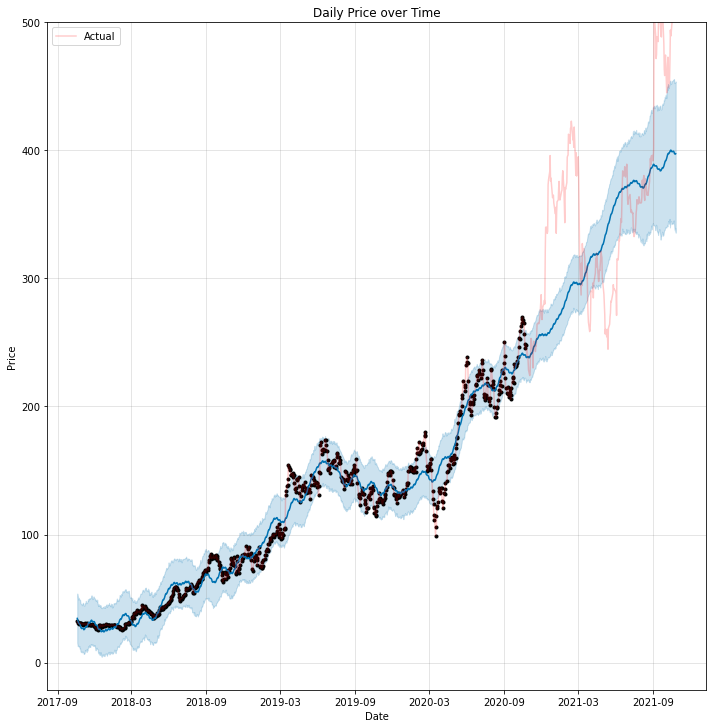

Test RMSE: 65.78887755293908


In [22]:
fb = create_prophet(data=df,logged=False,plotting=True,mse=True)

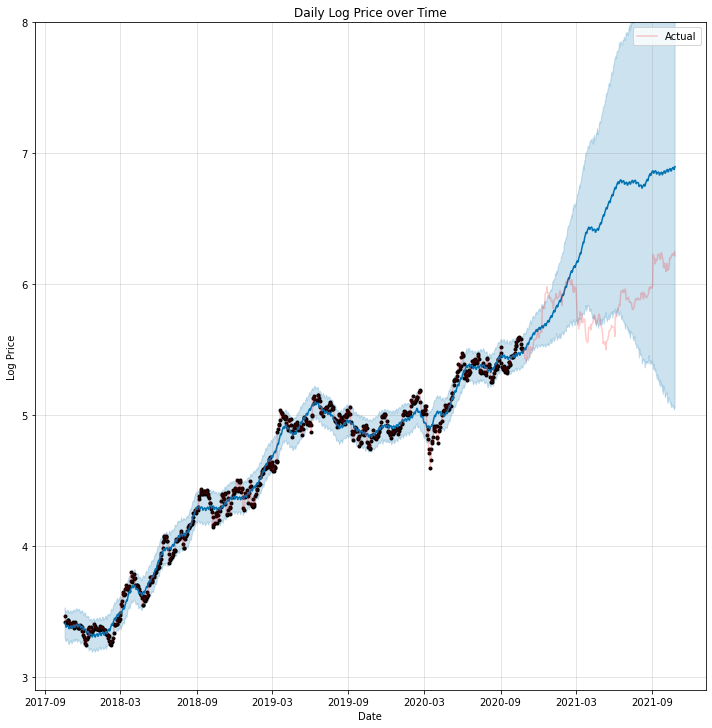

Test RMSE: 369.84401898575334


In [23]:
fb_logged = create_prophet(data=df,logged=True,plotting=True,mse=True)

### Facebook Prophet Findings
- Model with untransformed data has an RMSE of 65.8
- Model with log transformed data has a worse RMSE of 369.8
- In the vusualizations, the model with untransformed data provided a safe forecasting based on the trend
- However, the log transformed model overvalued the future prices

# Highest Growths in 60 Days
- Utilizing the best version of each model above, the models will be refit using the entire data set and forecasting the growth after 60 days

## Base Model Growth

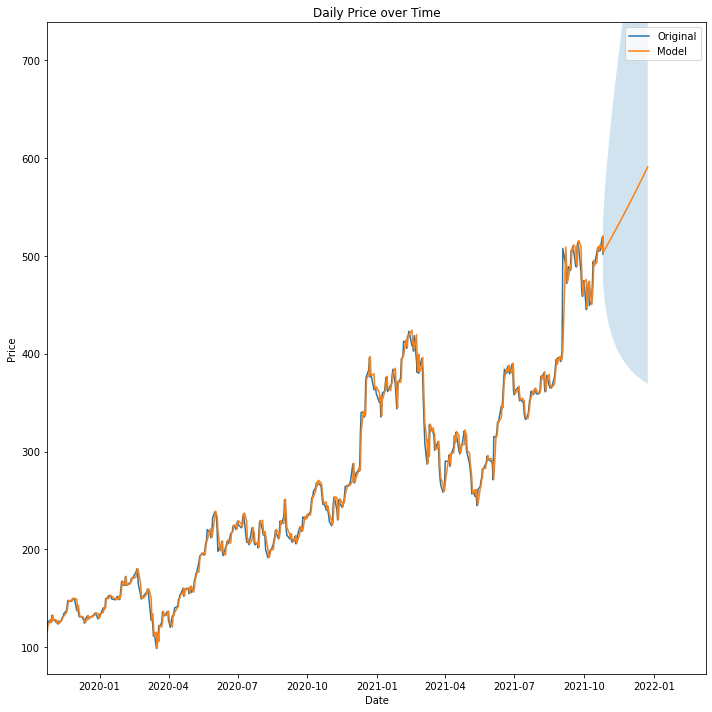

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1012
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1902.632
Date:                Sun, 14 Nov 2021   AIC                          -3801.265
Time:                        16:22:19   BIC                          -3791.428
Sample:                             0   HQIC                         -3797.528
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      2.315      0.021       0.000       0.005
sigma2         0.0014   3.41e-05     39.866      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.49   Jarque-

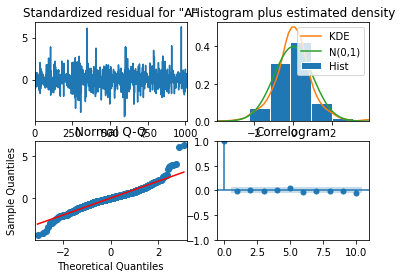

In [24]:
arima_60, arima_roi = base_model(df,exog=True,logged=True,plotting=True,summary=True,full=True,roi=True, return_roi=True)

## Auto ARIMA Growth

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3793.776, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3801.265, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3799.756, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3799.751, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3797.772, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3797.736, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.162 seconds


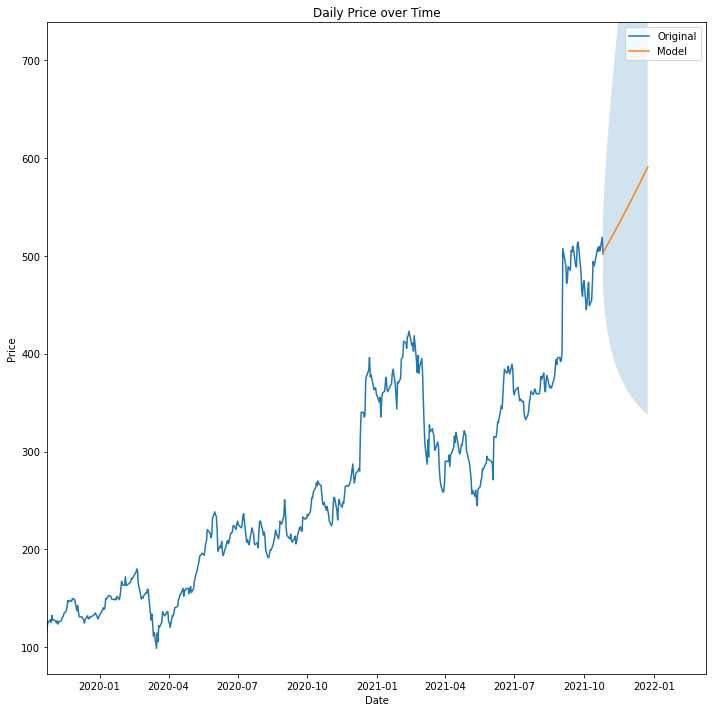

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1012
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1902.632
Date:                Sun, 14 Nov 2021   AIC                          -3801.265
Time:                        16:22:21   BIC                          -3791.428
Sample:                             0   HQIC                         -3797.528
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      2.315      0.021       0.000       0.005
sigma2         0.0014   3.41e-05     39.866      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.49   Jarque-

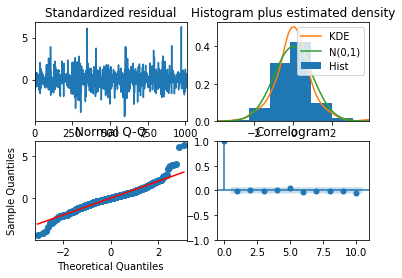

In [25]:
autoarima_60, autoarima_roi = create_auto_arima(df,exog=True,logged=True,plotting=True,
                                                summary=True,full=True,roi=True, return_roi=True)

## Facebook Prophet Growth

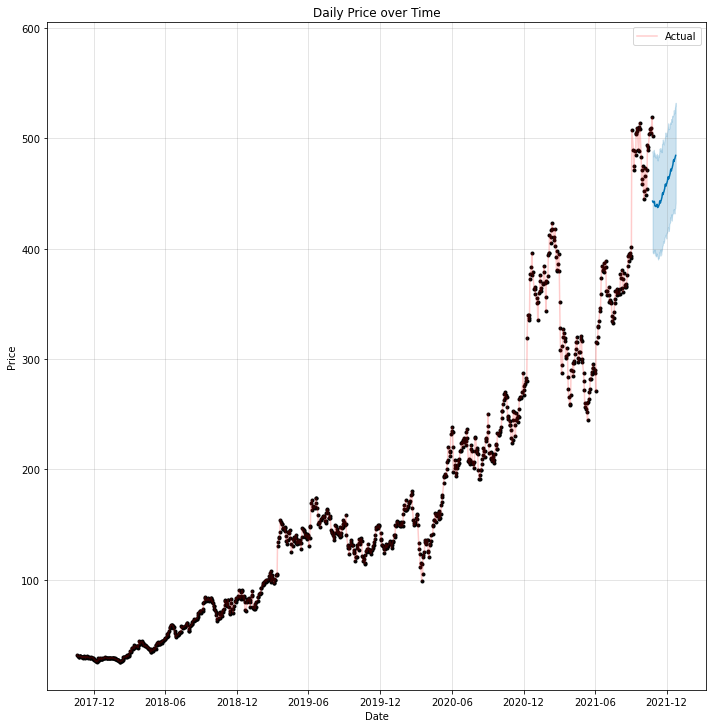

ROI:  -3.42 %


In [26]:
fb_60, fb_roi = create_prophet(df,exog=False,logged=False,plotting=True,full=True,roi=True, return_roi=True)

# Conclusions
- The ARIMA models expect a growth of ~ 17% after 60 days
- The Facebook Prophet model expects to lose ~3% after 60 days. However, it maintains a positive growth rate over time.
- Based on the models above, it looks like MongoDB would be a safe buy